---
title: Finite Difference
suptitle: Loops, Slicing, and Stencils
short_title: Finite Difference
date: 2023-02-21
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: PDE, ODE, TimeStepper, Diffrax
---

**Jax Methods**

* Loops
* Scanning
* Convolutions
* Stencils

In [143]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".home"])

# append to path
sys.path.append(str(root))

In [144]:
import jax
import jax.numpy as jnp
import numpy as np
import numba as nb
import equinox as eqx
import serket as sk
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Array, Float
import wandb

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's start with a simple 2D Linear Advection scheme. This PDE is defined as:

```{math}
:label: pde
\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0
```

For the PDE {eq}`pde`, we are going to do a forward difference discretization in space and a backwards in time. It is given by:

```{math}
:label: discretization_full
u_{i,j}^{n+1} = u_{i,j}^{n} - c \frac{\Delta t}{\Delta x}\left( u_{i,j}-u_{i-1,j}^n \right)
```

Citation [cite](dot:10.1175/JTECH-D-20-0104.1).

In [145]:
# defime some variables
tmax = 10.0
nt = 1_000
a = 1
dt = tmax / nt
t0 = tmax / 2
time = np.linspace(0, tmax, nt)

def fn(time, t0, a):
    return (1 / np.sqrt(2 * np.pi * a)) * np.exp(- (((time - t0)**2) / (2 * a)))

def dfn(time, t0, a):
    return (-(time - t0)/a) * (1/np.sqrt(2*np.pi*a))*np.exp(-(time-t0)**2/(2*a))


In [146]:
f = fn(time, t0, a)
df = dfn(time, t0, a)

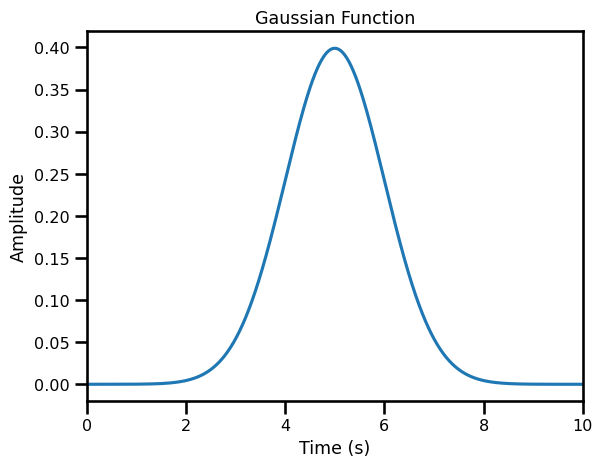

In [147]:
fig, ax = plt.subplots()
ax.plot(time, f)
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Amplitude",
    xlim=(0,tmax)
)
plt.show()

In [148]:
from jaxtyping import Array, Float

## Derivative Operators

Let's take some simple 1st order, first derivative formulations.

$$
\begin{aligned}
\mathcal{N}_\text{Forward}[u](x) &=  \frac{1}{\Delta x}(u_{i+1} + u_{i}) \\
\mathcal{N}_\text{Central}[u](x) &= \frac{1}{\Delta x}(\frac{1}{2}u_{i+1} - u_i - \frac{1}{2}u_{i-1}) \\
\mathcal{N}_\text{Backward}[u](x) &= \frac{1}{\Delta x}(u_i - u_{i-1}) \\
\end{aligned}
$$ (fd_schemes)



## Loops

I have to say, the easiest and clearest way to do this is the use loops! I think loops are readable and.

In [149]:
def diff_backward(u: Float[Array, "Nx"], dx: float) -> Float[Array, "Nx"]:
    
    un = np.zeros_like(u)
    for i in range(1, u.shape[0]):
        un[i] = (u[i] - u[i-1]) / dx
    return un

def diff_forward(u: Array, dx: float) -> Array:
    un = np.zeros_like(u)
    for i in range(0, u.shape[0]-1):
        un[i] = (u[i+1] - u[i]) / dx
    return un

def diff_central(u: Array, dx: float) -> Array:
    un = np.zeros_like(u)
    for i in range(1, u.shape[0]-1):
        un[i] = (0.5 * u[i+1] - 0.5 * u[i-1]) / dx
    return un

Unfortunately, python and loops is a bad idea...

In [150]:
solutions = dict()
solutions["loops"] = dict()

solutions["loops"]["forward"] = diff_forward(f, dt)
solutions["loops"]["backward"] = diff_backward(f, dt)
solutions["loops"]["central"] = diff_central(f, dt)

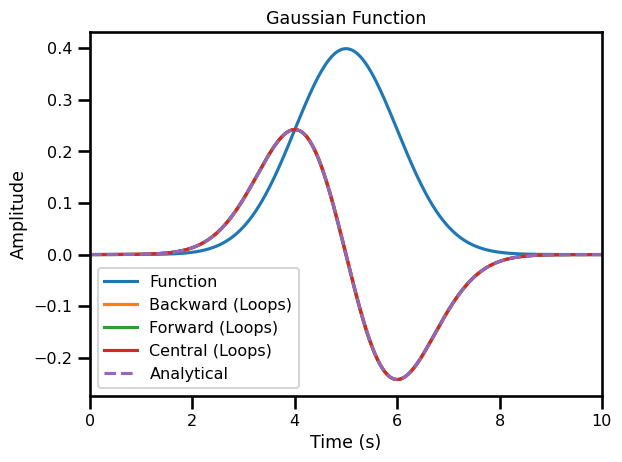

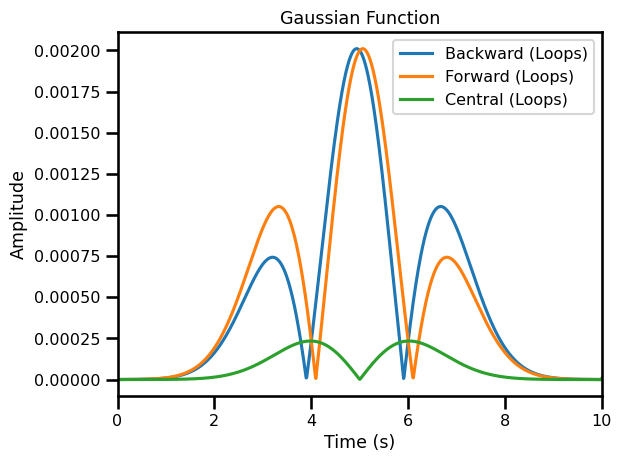

In [151]:
fig, ax = plt.subplots()
ax.plot(time, f, label="Function")
ax.plot(time, solutions["loops"]["backward"], label="Backward (Loops)")
ax.plot(time, solutions["loops"]["forward"], label=f"Forward (Loops)")
ax.plot(time, solutions["loops"]["central"], label=f"Central (Loops)")
ax.plot(time, df, label="Analytical", linestyle="--")
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Amplitude",
    xlim=(0,tmax)
)
plt.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
ax.plot(time, 
        np.abs(solutions["loops"]["backward"] - df), label="Backward (Loops)")
ax.plot(time, 
        np.abs(solutions["loops"]["forward"] - df), label="Forward (Loops)")
ax.plot(time, 
        np.abs(solutions["loops"]["central"] - df), label="Central (Loops)")
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Amplitude",
    xlim=(0,tmax)
)
plt.legend()
plt.tight_layout()
plt.show()

In [152]:
from jaxdf.conv import fd_coefficients_fornberg

In [153]:
# import typing as tp

# def get_fd_coefficients(
#     accuracy: int=2, 
#     order: int=1,
#     stagger: tp.Union[float, int]=0,
#     return_nodes: bool=False
# ):
#     r"""Returnst the stencil coefficients for a 1D Finite Differences derivative
#     operator.
    
#     Args:
#       x: FiniteDifferences field
#       order: Order of the derivative
#       stagger: Stagger of the derivative
      
#     Returns:
#       Stencil coefficients
#     """
#     # get points
#     points = np.arange(-accuracy // 2, accuracy // 2 + 1)

#     # stagger correction
#     if stagger > 0:
#         points = (points + stagger)[:-1]
#     elif stagger < 0:
#         points = (points + stagger)[1:]

#     # get coefficients
#     coeffs, nodes = fd_coefficients_fornberg(order, points, x0=0)
#     coeffs = coeffs.tolist()
#     nodes = nodes.tolist()
    
#     print(nodes)

#     # append zero
#     if stagger > 0:
#         coeffs = coeffs + [0.0]
#     elif stagger < 0:
#         coeffs = [0.0] + coeffs
#     if return_nodes:
#         return np.asarray(coeffs), np.asarray(nodes)
#     else:
#         return np.asarray(coeffs)
    
# def fd_derivative_init(dx, axis: int=0, accuracy: int=2, stagger=0, padding: str="extend"):
    
#     ndim = len(dx)
#     # get kernel
#     kernel = get_fd_coefficients(accuracy=accuracy, order=1, stagger=stagger, return_nodes=False)
    
#     if ndim > 1:
#         for _ in range(ndim - 1):
#             kernel = rearrange(kernel, "... -> ... 1")
        
#         # move kernel to correct axis
#         kernel = np.moveaxis(kernel, -1, axis)
    
#     # add dx
#     kernel = kernel / dx[axis]
    
#     return kernel
    
# def fd_pad(kernel, accuracy, stagger):
#     def fd_pad(x):
#         return (
#             (x - int(np.floor(accuracy/2))) - 1 - stagger, #+ (order//2 - 1)
#             (x - int(np.ceil(accuracy/2))) - 1 + stagger,
#         )
#     pad = [fd_pad(x) for x in kernel.shape]
#     return pad

# from jax import scipy as jsp


# def fd_convolve(x, kernel, pad=None, mode: str="valid"):
    
#     kernel = jnp.flip(kernel, axis=tuple(range(kernel.ndim)))
    
#     return jsp.signal.convolve(x, kernel, mode="valid")

### Test Cases:



:::{note} 
:class: dropdown
**Central Difference (1D)**

| Nodes | Kernel | Pad |
|:-----:|:------:|:---:|
|`[-1, 0, 1]` | | `(1,1)`|
| `[-2, 1, 0, 1]` | | `(2,1)` |
| `[-2, 1, 0, 1, 2]` | |   `(2,2)` |
| `[-2, 1, 0, 1, 2]` | |  `(2,2)` |
| `[-3, -2 1, 0, 1, 2]` | |  `(3,2)`|
| `[-3, -2, 1, 0, 1, 2, 3]`| |  `(3,3)`|



:::

:::{note}
:class: dropdown

**Forward Difference (1D)**

| Nodes | Kernel | Pad |
|:-----:|:------:|:---:|
|`[-1, 0, 1]` | `[-1/2, 0, 1/2]` | `(1,1)`|
| `[-2, 1, 0, 1]` | | `(2,1)` |
| `[-2, 1, 0, 1, 2]` | |   `(2,2)` |
| `[-2, 1, 0, 1, 2]` | |  `(2,2)` |
| `[-3, -2 1, 0, 1, 2]` | |  `(3,2)`|
| `[-3, -2, 1, 0, 1, 2, 3]`| |  `(3,3)`|

:::



## Slicing

Looking at the finite difference schemes {eq}`fd_schemes`, we have many different ways of doing the same derivative depending upon the situation. But in any case, in python classes, we are often taught to use slicing! We grab the sections of the array that correspond to the 







**Current Method**:

In python, we are often taught to do this manually. So basically for every numerical scheme, we have a specific way to slice the array.

```python
# forward
x = (x[:-1] - x[1:]) / dx

```


In [154]:
def diff_back_1d(u: Array, dx: float) -> Array:
    # pad array
    u = jnp.pad(u, pad_width=((0,1)), mode="edge")
    return (u[1:] - u[:-1]) / dx

def diff_forward_1d(u: Array, dx: float) -> Array:
    # pad array
    u = jnp.pad(u, pad_width=((1,0)), mode="edge")
    return (u[1:] - u[:-1]) / dx

def diff_central_1d(u: Array, dx: float) -> Array:
    # pad array
    u = jnp.pad(u, pad_width=((1,1)), mode="edge", )
    return (u[2:] - u[:-2]) / ( 2 * dx )

### Padding

This is an artefact of the slicing operation. Because we take a subset of the array, we are inevitably left with a small dimensions as the original array. For example, for the second order, the forward and backwards difference approaches remove one dimension from the original array from the front and back respectively. The central difference removes a element from the front and back.



Some options include:

* "constant": this adds the same element
* "edge": 
* "linear_ramp": 

In [155]:
def diff_forward_slice(u: Array, dx: float) -> Array:
    # pad array
    u = jnp.pad(u, pad_width=((0,1)), mode="edge")
    return (u[1:] - u[:-1]) / dx

def diff_central_slice(u: Array, dx: float) -> Array:
    # pad array
    u = jnp.pad(u, pad_width=((1,1)), mode="edge", )
    return (u[2:] - u[:-2]) / ( 2 * dx )

def diff_backward_slice(u: Array, dx: float) -> Array:
    # pad array
    u = jnp.pad(u, pad_width=((1,0)), mode="edge")
    return (u[1:] - u[:-1]) / dx



In [156]:
solutions["slice"] = dict()

solutions["slice"]["forward"] = diff_forward_slice(f, dt)
solutions["slice"]["backward"] = diff_backward_slice(f, dt)
solutions["slice"]["central"] = diff_central_slice(f, dt)

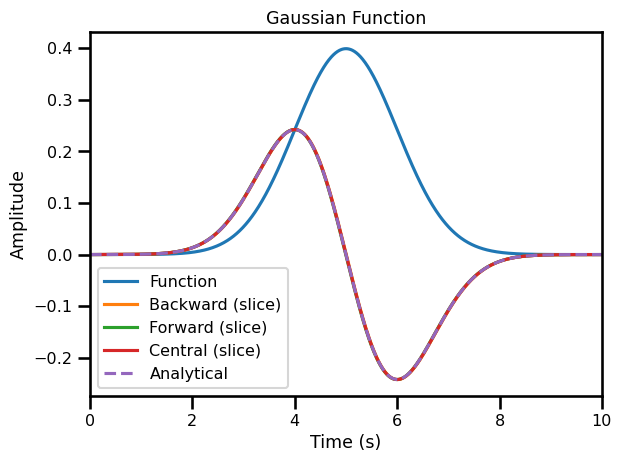

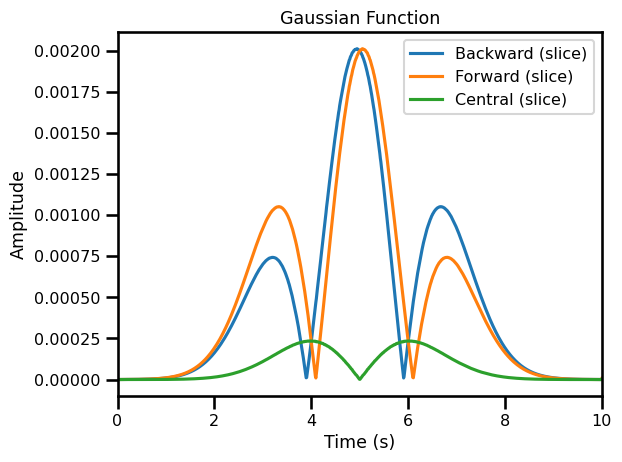

In [157]:
fig, ax = plt.subplots()
ax.plot(time, f, label="Function")
ax.plot(time, solutions["slice"]["backward"], label="Backward (slice)")
ax.plot(time, solutions["slice"]["forward"], label=f"Forward (slice)")
ax.plot(time, solutions["slice"]["central"], label=f"Central (slice)")
ax.plot(time, df, label="Analytical", linestyle="--")
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Amplitude",
    xlim=(0,tmax)
)
plt.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
ax.plot(time, 
        np.abs(solutions["slice"]["backward"] - df), label="Backward (slice)")
ax.plot(time, 
        np.abs(solutions["slice"]["forward"] - df), label="Forward (slice)")
ax.plot(time, 
        np.abs(solutions["slice"]["central"] - df), label="Central (slice)")
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Amplitude",
    xlim=(0,tmax)
)
plt.legend()
plt.tight_layout()
plt.show()

### Automating this

**Proposed Approach**:

```python
# calculate offsets
derivative: int = ...
accuracy: int = ...
method: str = "forward"
offsets: Tuple[int] = calculate_offsets(derivative, accuracy, method)

# calculate coefficients
coeffs: Tuple[float] = calculate_coefficients(offsets, derivative, method)

# calculate slices
x: Array = ...
slicer: Callable[Array] = calculate_slices(x, coeffs, method)

# do slicing
x: Array = slicer(x)
```

In [158]:
import finitediffx as fdx
# from jaxsw._src.operators.functional.fd import (
#     fd_forward_init, fd_central_init, fd_backward_init
# )
# from jaxsw._src.operators.functional.conv import fd_convolve
from jaxsw._src.operators.fd import Derivative

In [159]:
derivative = 1
accuracy = 2
axis = 0
dx = (dt,)

In [160]:
# get offsets
offsets = fdx._src.utils._generate_central_offsets(derivative=derivative, accuracy=accuracy)

print(f"Offsets: {offsets}")

Offsets: (-1, 0, 1)


This is consistent with the finite difference scheme ($-1 * a * u_{i-1} + 0 b * * u_i - 1 * c * u_{i-1}$). However, now we need to find the coefficients of this equation!

In [161]:
# get stencil
kernel = fdx._src.utils.generate_finitediff_coeffs(offsets, derivative=derivative)

print(f"Kernel: {kernel}")

Kernel: [-0.5  0.   0.5]


This is consistent with the proper finite difference scheme ($- 0.5 * u_{i-1} + 0 u_i - 0.5 * u_{i-1}$)

In [162]:
size = f.shape[axis]


print(f"Size of input dims: {size} (at axis {axis})")

Size of input dims: 1000 (at axis 0)


In [163]:
# padding
pad = ((1,1))
mode = "edge"

f_padded = jnp.pad(f, pad_width=pad, mode=mode)

In [165]:
# central difference
for ioffset, icoeff in zip(offsets, kernel):
    
    print(f"Raw: {icoeff} * slice({ioffset} - {offsets[0]}, {size} + ({ioffset} - {offsets[-1]})")
    print(f"Simplified: {icoeff} * slice({ioffset - offsets[0]}, {size + int(ioffset)-int(offsets[-1])}))\n")

Raw: -0.5 * slice(-1 - -1, 1000 + (-1 - 1)
Simplified: -0.5 * slice(0, 998))

Raw: 0.0 * slice(0 - -1, 1000 + (0 - 1)
Simplified: 0.0 * slice(1, 999))

Raw: 0.5 * slice(1 - -1, 1000 + (1 - 1)
Simplified: 0.5 * slice(2, 1000))



In [202]:
import functools as ft

# initialize slice object
sliced = ft.partial(jax.lax.slice_in_dim, f_padded, axis=axis)


center_x = sum(
    coeff * sliced(offset - offsets[0], size + (offset - offsets[-1]))
    for offset, coeff in zip(offsets, kernel)
)


print(center_x.shape, f[1:-1].shape)

# check closeness!
slice_soln = 0.5 * f[2:] - 0.5 * f[:-2]

# np.testing.assert_array_almost_equal(center_x/dt, (0.5 * f[2:] - 0.5 * f[:-2])/dt, decimal=4)

np.testing.assert_array_almost_equal(center_x, slice_soln, decimal=4)
# np.testing.assert_array_almost_equal(slice_soln, dt * df[2:-2], decimal=1)
# np.testing.assert_array_almost_equal(center_x, dt * df[2:-2], decimal=1)

(998,) (998,)


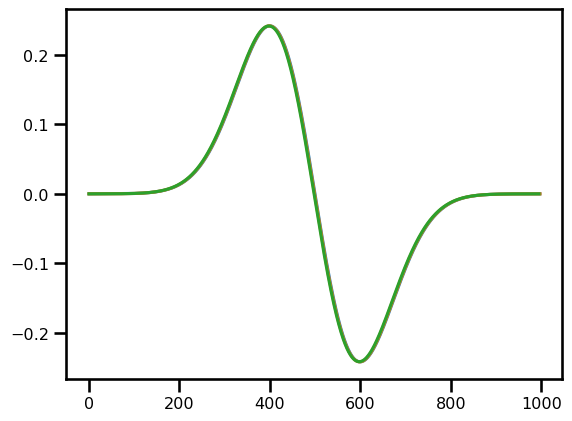

In [190]:
fig, ax = plt.subplots()

ax.plot(center_x/dt)
ax.plot((0.5 * f[2:] - 0.5 * f[:-2])/dt)
ax.plot(df[2:-2])
plt.show()

In [225]:
# padding
pad = ((4,4))
mode = "edge"

f_padded = jnp.pad(f, pad_width=pad, mode=mode)
size = f_padded.shape[axis]

# params
derivative = 1
accuracy = 4
axis = 0
dx = (dt,)

# get offsets
offsets = fdx._src.utils._generate_central_offsets(derivative=derivative, accuracy=accuracy)

print(f"Offsets: {offsets}")
# get stencil
kernel = fdx._src.utils.generate_finitediff_coeffs(offsets, derivative=derivative)

print(f"Kernel: {kernel}")

# initialize slice object
sliced = ft.partial(jax.lax.slice_in_dim, f_padded, axis=axis)


center_x = sum(
    coeff * sliced(offset - offsets[0], size + (offset - offsets[-1]))
    for offset, coeff in zip(offsets, kernel)
)

print(f.shape, f_padded.shape, center_x[2:-2].shape, df.shape)
np.testing.assert_array_almost_equal(center_x[2:-2]/dt, df, decimal=5)

Offsets: (-2, -1, 0, 1, 2)
Kernel: [ 8.3333328e-02 -6.6666663e-01 -1.2772423e-07  6.6666675e-01
 -8.3333336e-02]
(1000,) (1008,) (1000,) (1000,)


AssertionError: 
Arrays are not almost equal to 5 decimals

Mismatched elements: 582 / 1000 (58.2%)
Max absolute difference: 0.00024321
Max relative difference: 0.49148691
 x: array([ 3.78008e-06,  8.41230e-06,  8.18987e-06,  8.59074e-06,
        9.01029e-06,  9.44937e-06,  9.90879e-06,  1.03895e-05,
        1.08923e-05,  1.14183e-05,  1.19685e-05,  1.25439e-05,...
 y: array([ 7.43360e-06,  7.79908e-06,  8.18168e-06,  8.58216e-06,
        9.00129e-06,  9.43992e-06,  9.89888e-06,  1.03791e-05,
        1.08814e-05,  1.14069e-05,  1.19565e-05,  1.25313e-05,...

In [12]:
# def fd_convolve(
#     x: Array, 
#     kernel: Array, 
#     pad: tp.Optional[Array]=None, mode: str="edge") -> Array:
    
#     if pad is not None:
#         x = jnp.pad(x, pad_width=pad, mode=mode)
    
#     kernel = jnp.flip(kernel, axis=tuple(range(kernel.ndim)))
    
#     return jsp.signal.convolve(x, kernel, mode="valid")

In [56]:
dx = (dt,)
axis = 0
accuracy = 8
derivative = 1
mode = "edge"
method = "central"

operator = Derivative(
    dx=dx, 
    axis=axis,
    accuracy=accuracy,
    derivative=derivative,
    mode=mode,
    method=method
)


operator

Derivative(
  kernel=f32[9],
  padding=(4, 4),
  axis=0,
  derivative=1,
  accuracy=8,
  dx=(0.01,),
  mode='edge',
  method='central'
)

In [51]:
operator.kernel, operator.padding

(Array([-50.,   0.,  50.], dtype=float32), (1, 1))

In [52]:
soln = operator(f)

assert soln.shape == f.shape

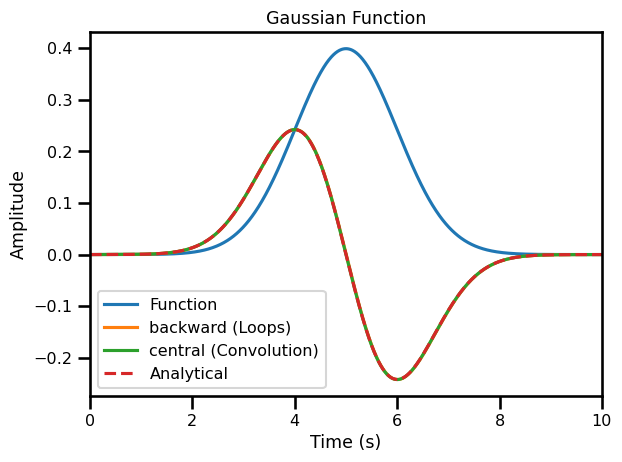

In [53]:
fig, ax = plt.subplots()
ax.plot(time, f, label="Function")
ax.plot(time, sol, label="backward (Loops)")
ax.plot(time, soln, label=f"{method} (Convolution)")
ax.plot(time, df, label="Analytical", linestyle="--")
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Amplitude",
    xlim=(0,tmax)
)
plt.legend()
plt.tight_layout()
plt.show()

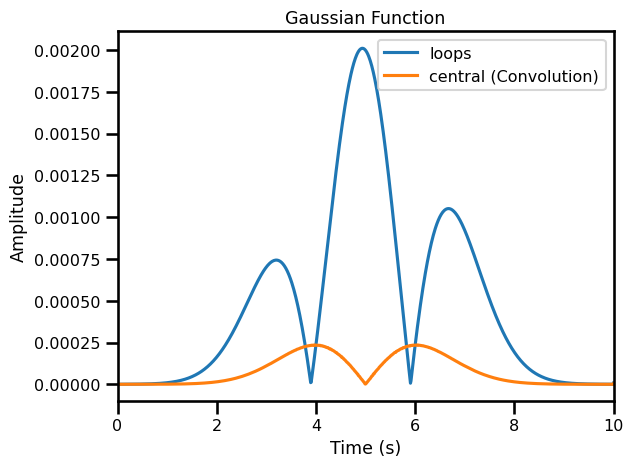

In [54]:
fig, ax = plt.subplots()
ax.plot(time, 
        np.abs(sol - df), label="loops")
ax.plot(time, 
        np.abs(soln - df), label=f"{method} (Convolution)")
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Amplitude",
    xlim=(0,tmax)
)
plt.legend()
plt.show()

In [99]:
dx = (dt,)
accuracy = 4
derivative = 1

kernel, padding = fd_forward_init(dx, axis=0, accuracy=accuracy, derivative=derivative)

kernel, padding

(Array([-208.33337 ,  400.0002  , -300.0003  ,  133.33351 ,  -25.000036],      dtype=float32),
 (0, 4))

In [100]:
dx = (dt,)
accuracy = 4
derivative = 1

kernel, padding = fd_backward_init(dx, axis=0, accuracy=accuracy, derivative=derivative)

kernel, padding

(Array([  24.99999, -133.33328,  299.99988, -399.9999 ,  208.33331],      dtype=float32),
 (4, 0))

In [30]:
from einops import repeat, rearrange

dx = (1,) #(dt,)
axis = 0
accuracy = 2
stagger = 0
padding = "extend"

# convolutional kernel
kernel = fd_derivative_init(dx=dx, axis=axis, accuracy=accuracy, stagger=stagger, padding=padding)

# padding
pad = fd_pad(kernel, accuracy=accuracy, stagger=stagger)
mode = "edge" # "wrap", 
f_padded = jnp.pad(f, pad, mode=mode)

# convolution
sol = fd_convolve(f_padded, kernel, mode=mode)
kernel, pad, sol.shape

[-1, 0, 1]


(array([-0.5, -0. ,  0.5]), [(1, 1)], (1000,))

In [18]:
accuracy = 2
order = 1
stagger = 0
return_nodes = True
kernel, nodes = get_fd_coefficients(accuracy=accuracy, order=order, stagger=stagger, return_nodes=return_nodes)

print(kernel, nodes)

[-0.5 -0.   0.5] [-1  0  1]


In [472]:
def fd_coeffs_dims(coeffs, ndim=0):
    if ndim > 0:
        for _ in range(ndim - 1):
            kernel

In [475]:
accuracy = 2
order = 1
stagger = -1

kernel = get_fd_coefficients(accuracy=accuracy, order=order, stagger=stagger)

# number dims
ndim = 1
axis = 0
dx = dt

# add kernels
for _ in range(ndim - 1):
    kernel = np.expand_dims(kernel, axis=0)
    
# move kernel to correct axis
kernel = np.moveaxis(kernel, -1, axis)

# add dx
# kernel = kernel / dx

# reverse kernel
kernel = jnp.flip(kernel, axis=tuple(range(kernel.ndim)))

def fd_pad(x, accuracy, stagger):
    return (
        (kernel.shape[0] - int(np.floor(accuracy/2))) - 1 - stagger, #+ (order//2 - 1)
        (kernel.shape[0] - int(np.ceil(accuracy/2))) - 1 + stagger,
    )
pad = [fd_pad(x, accuracy, stagger) for x in kernel.shape]
kernel.shape, pad

[-1  0]
[ 1. -1.  0.]


((3,), [(2, 0)])

In [467]:
(kernel.shape[0] - (accuracy//2) - 1)

1

In [456]:

pad

[(3, 1)]

In [122]:
(kernel.shape[0]-1)//2

1

In [ ]:
def get_pad(kernel, stagger=0):
    
    return

In [120]:
kernel.shape

(3,)

In [118]:
pad = [((x-1)//2,(x-1)//2) for x in kernel.shape]
f_padded = jnp.pad(f, pad, mode="edge")
sol = jnp.convolve(f_padded, kernel, mode="valid")


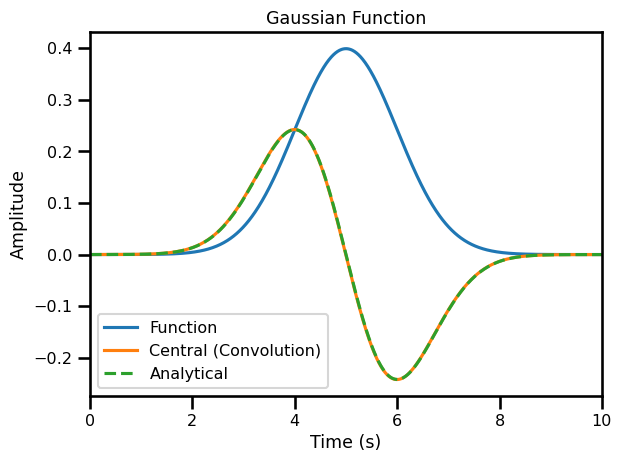

In [119]:
fig, ax = plt.subplots()
ax.plot(time, f, label="Function")
ax.plot(time, sol, label="Central (Convolution)")
ax.plot(time, df, label="Analytical", linestyle="--")
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Amplitude",
    xlim=(0,tmax)
)
plt.legend()
plt.tight_layout()
plt.show()

In [72]:
# accuracy
accuracy = 2

points = np.arange(-accuracy // 2, accuracy // 2 + 1)

# stagger
stagger = -1
if stagger > 0:
    points = (points + stagger)[:-1]
elif stagger < 0:
    points = (points + stagger)[1:]

# get coefficients
order = 1
coeffs = fd_coefficients_fornberg(order, points, x0=0)[0].tolist()

# append zero
if stagger > 0:
    coeffs = coeffs + [0.0]
elif stagger < 0:
    coeffs = [0.0] + coeffs

# return kernel

In [73]:
coeffs

[0.0, -1.0, 1.0]

In [18]:
points, accuracy

(Array([-3, -2, -1,  0,  1,  2,  3,  4], dtype=int32), 8)

In [15]:
points

Array([-4, -3, -2, -1,  0,  1,  2,  3,  4], dtype=int32)

In [ ]:
# stencil = jnp.ones(2) / dx
# sol = jnp.convolve(u, stencil, mode="same")

In [9]:
def diff_back_1d_loop(u: Float[Array, "Nx"], dx: float) -> Float[Array, "Nx"]:
    
    un = np.zeros_like(u)
    for i in range(1, u.shape[0]-1):
        un[i] = (u[i+1] - u[i])/dx
    return un

def diff_forward_1d_loop(u: Float[Array, "Nx"], dx: float) -> Float[Array, "Nx"]:
    un = np.zeros_like(u)
    for i in range(1, u.shape[0]-1):
        un[i] = (u[i] - u[i-1])/dx
    return un

def diff_central_1d_loop(u: Float[Array, "Nx"], dx: float) -> Float[Array, "Nx"]:
    un = np.zeros_like(u)
    for i in range(1, u.shape[0]-1):
        un[i] = (u[i+1] - u[i-1])/(2*dx)
    return un

def diff_back_1d(u: Float[Array, "Nx"], dx: float) -> Float[Array, "Nx"]:
    # pad array
    u = jnp.pad(u, pad_width=((0,1)), mode="constant")
    return (u[1:] - u[:-1]) / dx

def diff_forward_1d(u: Float[Array, "Nx"], dx: float) -> Float[Array, "Nx"]:
    # pad array
    u = jnp.pad(u, pad_width=((1,0)), mode="constant")
    return (u[1:] - u[:-1]) / dx

def diff_central_1d(u: Float[Array, "Nx"], dx: float) -> Float[Array, "Nx"]:
    # pad array
    u = jnp.pad(u, pad_width=((1,1)), mode="constant")
    return (u[2:] - u[:-2]) / ( 2 * dx )

In [10]:
np.diff(f, n=1).shape, f.shape

((999,), (1000,))

In [11]:
derivatives = dict()
f = fn(time, t0, a)
derivatives["backward_loop"] = diff_back_1d_loop(f, dx=dt)
derivatives["forward_loop"] = diff_forward_1d_loop(f, dx=dt)
derivatives["central_loop"] = diff_central_1d_loop(f, dx=dt)

derivatives["backward_slice"] = diff_back_1d(f, dx=dt)
derivatives["forward_slice"] = diff_forward_1d(f, dx=dt)
derivatives["central_slice"] = diff_central_1d(f, dx=dt)
# serket 

np.testing.assert_array_almost_equal(derivatives["backward_loop"][1:-1], derivatives["backward_slice"][1:-1], decimal=5)
np.testing.assert_array_almost_equal(derivatives["forward_loop"][1:-1], derivatives["forward_slice"][1:-1], decimal=5)
np.testing.assert_array_almost_equal(derivatives["central_loop"][1:-1], derivatives["central_slice"][1:-1], decimal=5)

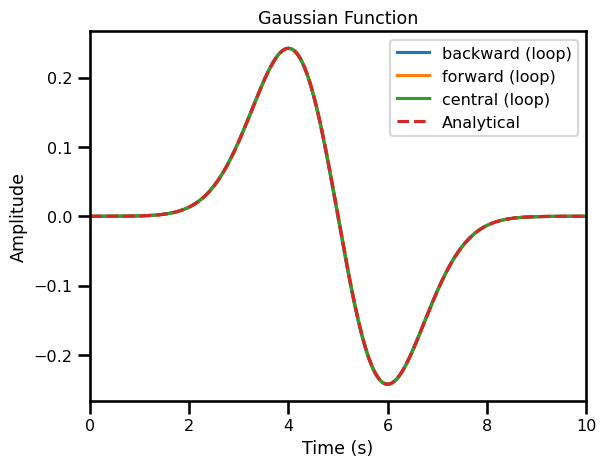

In [12]:
fig, ax = plt.subplots()
ax.plot(time, derivatives["backward_loop"], label="backward (loop)")
ax.plot(time, derivatives["forward_loop"], label="forward (loop)")
ax.plot(time, derivatives["central_loop"], label="central (loop)")
ax.plot(time, df, label="Analytical", linestyle="--")
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Amplitude",
    xlim=(0,tmax)
)
plt.legend()
plt.show()

## Finite Difference Coefficients

In [197]:
import serket as sk

derivatives["serket"] = sk.fd.difference(f, axis=0, accuracy=2, step_size=dt)
np.testing.assert_array_almost_equal(derivatives["serket"][1:-1], derivatives["central_slice"][1:-1], decimal=3)

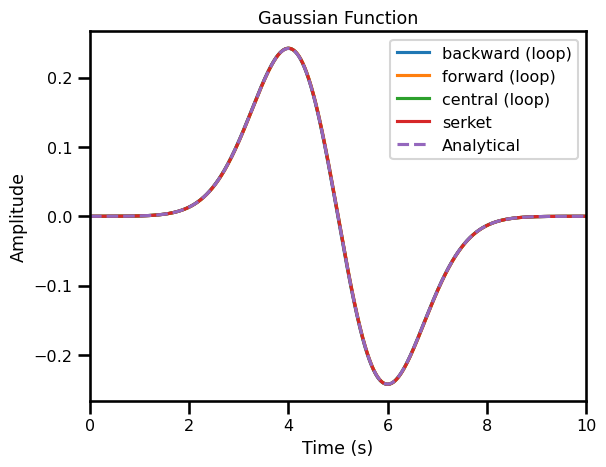

In [198]:
fig, ax = plt.subplots()
ax.plot(time, derivatives["backward_loop"], label="backward (loop)")
ax.plot(time, derivatives["forward_loop"], label="forward (loop)")
ax.plot(time, derivatives["central_loop"], label="central (loop)")
ax.plot(time, derivatives["serket"], label="serket")
ax.plot(time, df, label="Analytical", linestyle="--")
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Amplitude",
    xlim=(0,tmax)
)
plt.legend()
plt.show()

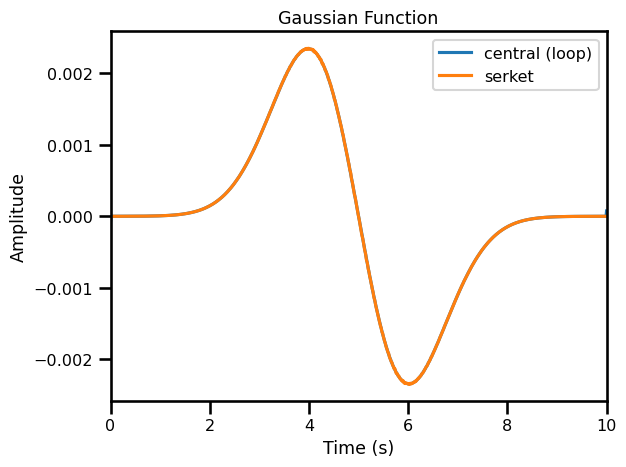

In [199]:
fig, ax = plt.subplots()
ax.plot(time, 
        10*(derivatives["central_loop"] - df), label="central (loop)")
ax.plot(time, 
        10*(derivatives["serket"] - df), label="serket")
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Amplitude",
    xlim=(0,tmax)
)
plt.legend()
plt.show()

So let's rewrite the PDE only looking at the spatial discretization.

```{math}
:label: discretization_spatial
\partial_t u = - c \frac{1}{\Delta x}\left( u_{i}-u_{i-1}^n \right) 
```


In [219]:
import kernex as kex

    
@kex.kmap(kernel_size=(3,), padding="same", relative=True)
def fd_central_kernel(u, dx):
    return (u[1] - u[-1]) / (2 * dx)
    

def fd_central_loop(u: Float[Array, "Nx"], dx: float) -> Float[Array, "Nx"]:
    un = jnp.zeros_like(u)
    for i in range(1, u.shape[0]-1):
        un = un.at[i].set((u[i+1] - u[i-1])/(2*dx))
    return un

def fd_central_slice(u: Float[Array, "Nx"], dx: float) -> Float[Array, "Nx"]:
    # pad array
    u = jnp.pad(u, pad_width=((1,1)), mode="constant")
    return (u[2:] - u[:-2]) / ( 2 * dx )

In [230]:
%timeit fd_central_kernel(f, dt).block_until_ready()
%timeit fd_central_loop(f, dt).block_until_ready()
%timeit fd_central_slice(f, dt).block_until_ready()
%timeit sk.fd.difference(f, axis=0, accuracy=2, step_size=dt).block_until_ready()

2.81 ms ± 32 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
363 ms ± 19.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
286 µs ± 1.57 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
6.98 µs ± 24.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [231]:
from functools import partial
fn = jax.jit(fd_central_kernel, static_argnums=(1,))
%timeit fn(f, dt).block_until_ready()
fn = jax.jit(fd_central_loop, static_argnums=(1,))
%timeit fn(f, dt).block_until_ready()
fn = jax.jit(fd_central_slice, static_argnums=(1,))
%timeit fn(f, dt).block_until_ready()
fn = partial(sk.fd.difference, axis=0, accuracy=2, step_size=dt)
fn = jax.jit(fn, static_argnums=(1,2,3,))
%timeit fn(f).block_until_ready()

4.07 µs ± 24.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
8.67 µs ± 28.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
3.66 µs ± 64.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
8.98 µs ± 4.32 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [210]:
derivatives = dict()

derivatives["kernel"] = fd_central_kernel(f, dt)
derivatives["loop"] = fd_central_loop(f, dt)
derivatives["slice"] = fd_central_slice(f, dt)
derivatives["serket"] = sk.fd.difference(f, axis=0, accuracy=2, step_size=dt)

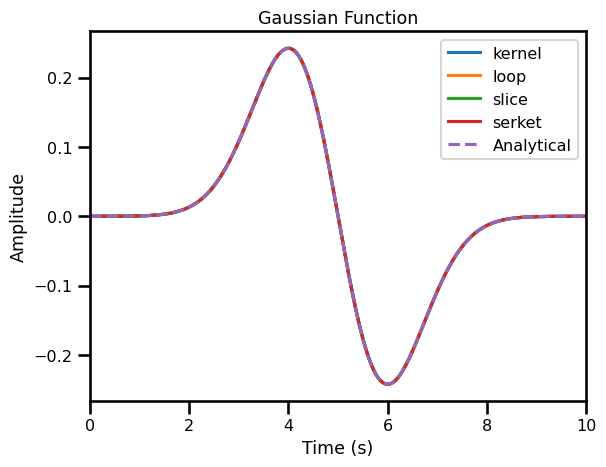

In [211]:
fig, ax = plt.subplots()
ax.plot(time, derivatives["kernel"], label="kernel")
ax.plot(time, derivatives["loop"], label="loop")
ax.plot(time, derivatives["slice"], label="slice")
ax.plot(time, derivatives["serket"], label="serket")
ax.plot(time, df, label="Analytical", linestyle="--")
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Amplitude",
    xlim=(0,tmax)
)
plt.legend()
plt.show()

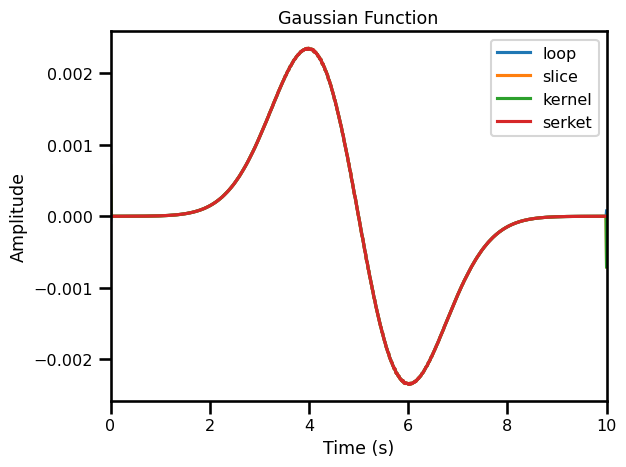

In [214]:
fig, ax = plt.subplots()
ax.plot(time, 
        10*(derivatives["loop"] - df), label="loop")
ax.plot(time, 
        10*(derivatives["slice"] - df), label="slice")
ax.plot(time, 
        10*(derivatives["kernel"] - df), label="kernel")
ax.plot(time, 
        10*(derivatives["serket"] - df), label="serket")
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Amplitude",
    xlim=(0,tmax)
)
plt.legend()
plt.show()